In [1]:
import pandas as pd

user_data = pd.read_csv("csv/all_user_data_c_50_90_s.csv")

In [2]:
user_data.drop(user_data.columns[[0]], axis=1, inplace=True)
user_data.head()

,id,name,editcount,status
0,228,!dea4u,1,1
1,1350,$uperFan32,1,1
2,2346,***Ria777,1,1
3,2460,*AirportUpdater*,1,1
4,2555,*Kat*,1,1


In [3]:
user_data = user_data[user_data['status']>0]
user_data = user_data[:1500]  # same as df.head(10)

In [4]:
user_data.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,id,editcount,status
count,1500,1500,1500
mean,1.52381e+06,1,1
std,820612,0,0
min,228,1,1
25%,801058,1,1
50%,1.56195e+06,1,1
75%,2.2514e+06,1,1
max,2.88764e+06,1,1


In [5]:

import os.path
import numpy as np
from trust_score import TrustScore
from sklearn import metrics
from sklearn.linear_model import LinearRegression
import json

y_pred = []
y_test=[]
cou = 0

for row in user_data.iterrows():
    path = 'user_data_50_90_b_e/rev_list_' + str(row[1]['id']) + '-dp.json'
    #print(path)
    try:
        with open(path, 'r') as infile:
            data = json.loads(infile.read())

            if len(data) > 0:
                for d in data:
                    del d['next_rev']

                graph_for = "longevityRev"

                series = pd.DataFrame(data=data)
                series = series[['pageid', 'timestamp', graph_for]]
                series = series[series.longevityRev >= 0]
                if len(series) > 9:
                    print('User ID: ', str(row[1]['id']))
                    series['longevityRevA'] = series.iloc[:,2].rolling(window=4).mean()
                    series['longevityRevA'] = series['longevityRevA'].apply(lambda x: round(x, 2))
                    series.iloc[0:3,3]=series.iloc[0:3,2]
                    series['longevityRev'] = series['longevityRevA']
                    #print(series.head())
                    series['Trust'] = TrustScore([series[graph_for],48]).calculate()
                    series['longevityRevN'] = series['longevityRev'].shift(-1)
                    series['longevityRevP'] = series['longevityRev'].shift(1)
                    series = series[series.longevityRevP >= 0]
                    series = series[series.longevityRevN >= 0]
                    series = series[series.longevityRev >= 0]

                    seriesTrain = series[0:-1]
                    seriesTest = series[len(series)-1:]
                    #print(series)
                    regressor = LinearRegression()
                    regressor.fit(seriesTrain[['Trust']], seriesTrain['longevityRevN'])

                    # To retrieve the intercept:
                    print(regressor.intercept_)
                    # For retrieving the slope:
                    print(regressor.coef_)

                    pred = regressor.predict(seriesTest[['Trust']])
                    print('Data Count: ', len(seriesTrain))
                    print('Test Data: ')
                    print(seriesTest[['Trust', 'longevityRev','longevityRevP']])
                    print('predicted: ',pred, ' actual: ', seriesTest['longevityRevN'].values[0])
                    print("##########################")
                    if(pred>=0):
                        y_test.append(seriesTest['longevityRev'].values[0])
                        y_pred.append(pred[0])
    except Exception as e:
        #print('error :',e.message)
        cou= cou+1


# print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
# print('R2 Score:', metrics.r2_score(y_test, y_pred))
# print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
# print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
correlation_matrix = np.corrcoef(y_test, y_pred)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2
print('R value:', correlation_xy)
print('R 2 value:', r_squared)
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

User ID:  2346
0.42164826731085325
[34.32992166]
Data Count:  109
Test Data: 
        Trust  longevityRev  longevityRevP
132  0.187657          5.75          17.75
predicted:  [6.8639005]  actual:  1.75
##########################
User ID:  3201
8.15770171187454
[31.65158896]
Data Count:  276
Test Data: 
        Trust  longevityRev  longevityRevP
310  0.066331         18.25           28.0
predicted:  [10.25719593]  actual:  6.25
##########################
User ID:  3437
3.531093943308174
[27.76463733]
Data Count:  18
Test Data: 
       Trust  longevityRev  longevityRevP
24  0.432061          14.0          16.25
predicted:  [15.5270994]  actual:  13.25
##########################
User ID:  3469
4.768167597612319
[28.58252226]
Data Count:  10
Test Data: 
       Trust  longevityRev  longevityRevP
22  0.331188          12.5           4.75
predicted:  [14.2343567]  actual:  14.0
##########################
User ID:  4191
7.27745750789874
[27.1060099]
Data Count:  172
Test Data: 
        Trust 

In [6]:
longevity_list = pd.DataFrame({'actual':y_test, 'predicted':y_pred})
longevity_list.to_csv("all_user_data_predicted.csv")

In [20]:

longevity_list.describe()


,actual,predicted
count,67.000000,67.000000
mean,15.902985,16.696290
std,10.899590,10.411690
min,0.000000,1.709366
25%,6.000000,8.892670
50%,14.500000,14.173572
75%,24.750000,23.335431
max,47.000000,50.382627


In [93]:
longevity_list = longevity_list[longevity_list['actual']>5]

In [26]:
longevity_list.describe()

,actual,predicted
count,155.000000,155.000000
mean,0.759677,1.013659
std,2.536564,2.968929
min,0.000000,0.000000
25%,0.000000,0.009143
50%,0.000000,0.153736
75%,0.250000,0.747056
max,22.250000,30.686348


In [76]:
longevity_list['sum'] = longevity_list['actual']+longevity_list['predicted']

In [85]:
longevity_list.describe()

,actual,predicted,sum,error
count,586.000000,586.000000,586.000000,586.000000
mean,27.573379,27.611827,55.185206,-0.038448
std,10.768333,10.126758,19.474796,7.599263
min,5.250000,1.481666,9.574922,-19.100161
25%,19.500000,19.964361,40.453350,-5.578922
50%,27.000000,27.555240,54.823573,-0.091775
75%,36.000000,35.070486,70.003419,5.173237
max,48.000000,53.933310,101.933310,26.141187


In [7]:
correlation_matrix = np.corrcoef(longevity_list['actual'], longevity_list['predicted'])
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2
print('R value:', correlation_xy)
print('R 2 value:', r_squared)

R value: 0.6393325631730091
R 2 value: 0.4087461263333697


In [8]:
longevity_list['error'] = longevity_list['actual']-longevity_list['predicted']

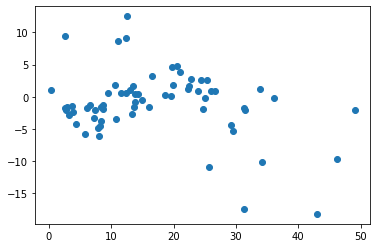

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(x=longevity_list['predicted'], y=longevity_list['error'])
plt.show()

In [60]:
longevity_list = longevity_list[longevity_list['actual']<40]

In [9]:
correlation_matrix = np.corrcoef(longevity_list['predicted'], longevity_list['error'])
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2
print('R value:', correlation_xy)
print('R 2 value:', r_squared)

R value: -0.11718650906540151
R 2 value: 0.01373267790693543


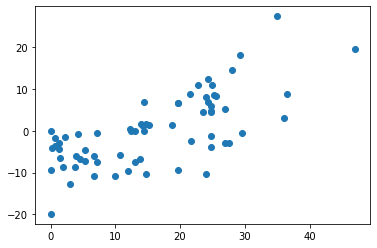

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(x=longevity_list['actual'], y=longevity_list['error'])
plt.show()

In [10]:
correlation_matrix = np.corrcoef(longevity_list['actual'], longevity_list['error'])
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2
print('R value:', correlation_xy)
print('R 2 value:', r_squared)

R value: 0.6887112044810196
R 2 value: 0.4743231231776968


Text(0, 0.5, 'Count')

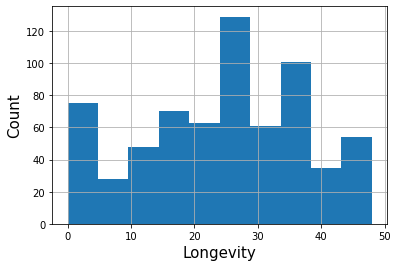

In [81]:
longevity_list['actual'].hist(bins=10)
plt.xlabel("Longevity", fontsize=15)
plt.ylabel("Count",fontsize=15)